<a href="https://colab.research.google.com/github/LSENeutralNetwork/Artificial-Intelligence-Deep-Learning/blob/master/Assignment_1_Part_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 3
Candidate Number: 43335

# 3.1 Load TensorFlow and Libraries

In [0]:
# Load Correct Version of TensorFlow
import tensorflow as tf
%tensorflow_version 1.x
tf.logging.set_verbosity(tf.logging.INFO)

# Load Libraries, Data and Set Seed
from keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(1)

# 3.2 Functions for Normalisation, One-Hot Encoding, Plot Loss, Plot Error


Design and implement a convolutional neural network for the CIFAR10 image classification task aiming to achieve a high test accuracy. Evaluate the classification accuracy by reporting top-1 and top-5 test error rates.

**Task:** plot the average loss, top-1 error rate and top-5 error rate per epoch versus the number of epochs for the training and the test dataset. Make sure to well describe and justify your network architecture design choices.

In [0]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    return x

def one_hot_encode(x):
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

def plot_loss(losstrain, losstest):
    plt.plot(losstrain, label='Training Loss')
    plt.plot(losstest, label='Test Loss')
    plt.title('Average Training and Test Loss per Epoch')
    plt.xlabel('Number of Epoches')
    plt.ylabel('Cross Entropy Loss')
    plt.legend()
    plt.show()

def plot_error(errortrain, errortest, top1 = False):
    plt.plot(errortrain, label='Training Error')
    plt.plot(errortest, label='Test Error')
    if top1:
      plt.title('Training and Test Top 1 Error per Epoch')
    else:
      plt.title('Testining and Test Top 5 Error per Epoch')
    plt.xlabel('Number of Epoches')
    plt.ylabel('Error')
    plt.legend()
    plt.show()

# 3.3 Function for CNN

According to many articles, the VGG-16 model is supposedly one of the best network architectures for this task with the highest test accuracy 

Source: https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#c5a6

The VGG-16 Model has the following architecture:
- 2 convolutional layers, 1 pool layer
- 2 convolutional layers, 1 pool layer
- 3 convolutional layers, 1 pool layer
- 3 convolutional layers, 1 pool layer
- 3 convolutional layers, 1 pool layer
- 3 dense layers
Source: https://neurohive.io/en/popular-networks/vgg16/ (see references at the end)

The final architecture I chose is based on the VGG-16 model but a little bit more simplified with the following specifications:
- 2 convolutional layers (with batch normalisation), 1 pool layer, 1 dropout layer (20%)
- 3 convolutional layers (with batch normalisation), 1 pool layer, 1 dropout layer (20%)
- 1 dense layer, 1 dropout layer (40%)

This yielded the highest accuracy (81.5%)



In [0]:
def classification_cnn(data, training=False):
    with tf.variable_scope('classification_cnn', reuse=tf.AUTO_REUSE):
        # TensorFlow’s convolutional conv2d operation expects a 4-dimensional tensor
        #  with dimensions corresponding to batch, width, height and channel.
        inputs = tf.reshape(data, [-1, 32, 32, 3])

        # Convolutional Layer 1
        conv1 = tf.layers.conv2d(inputs=inputs, filters=32, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)
        # Batch Normalisation 1
        normbatch1 = tf.compat.v1.layers.batch_normalization(inputs=conv1)

        # Convolutional Layer 2
        conv2 = tf.layers.conv2d(inputs=normbatch1, filters=64, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)
        # Batch Normalisation 2
        normbatch2 = tf.compat.v1.layers.batch_normalization(inputs=conv2)
        # Pooling Layer 1
        pool1 = tf.layers.max_pooling2d(inputs=normbatch2, pool_size=[2, 2], strides=2)
        # Drop Out Layer 1 (20%)
        dropout1 = tf.layers.dropout(inputs=pool1, rate=0.2, training=training)

        # Convolutional Layer 3
        conv3 = tf.layers.conv2d(inputs=dropout1, filters=128, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)  
        # Batch Normalisation 3
        normbatch3 = tf.compat.v1.layers.batch_normalization(inputs=conv3)  

        # Convolutional Layer 4
        conv4 = tf.layers.conv2d(inputs=normbatch3, filters=128, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)    
        # Batch Normalisation 4
        normbatch4 = tf.compat.v1.layers.batch_normalization(inputs=conv4)  

        # Convolutional Layer 5
        conv5 = tf.layers.conv2d(inputs=normbatch4, filters=128, kernel_size=[5, 5], strides=1, padding="same", activation=tf.nn.relu)    
        # Batch Normalisation 5
        normbatch5 = tf.compat.v1.layers.batch_normalization(inputs=conv5)  
        # Pooling Layer 2
        pool2 = tf.layers.max_pooling2d(inputs=normbatch5, pool_size=[4, 4], strides=4)
        # Drop Out Layer 2 (20%)
        dropout2 = tf.layers.dropout(inputs=pool2, rate=0.2, training=training)

        p3_flat = tf.reshape(dropout2, [-1, 4 * 4 * 128])  # 2048 dims

        # Dense Layer
        h1 = tf.layers.dense(inputs=p3_flat, units=1000, activation=tf.nn.relu)
        # Drop Out Layer 4 (40%)
        dropout3 = tf.layers.dropout(inputs=h1, rate=0.4, training=training)

        # Output layer
        outputs = tf.layers.dense(inputs=dropout3, units=10, activation=None)
    return outputs

# 3.4 Function for Classification CIFAR-10

* Use num_epoches = 100 in this case, but it really is up to us to try out a smaller or larger number of epoches 
* Normalise training and test data and labels
* Use Adam Optimiser as it was the best in the previous two problems

In [0]:
def CIFAR_classification(num_epoches):

  # Load Data
  (data_train, label_train), (data_test, label_test) = cifar10.load_data()

  # Set Hyper-parameters
  x_dim = 3072
  num_classes = 10
  num_epoches = num_epoches
  batch_size = 128
  learning_rate = 0.001
  n_batches = 50
  length_data = len(data_train)
  random_idx = np.arange(length_data)

  # Normalise Data and One-Hot Encode Labels
  norm_training_data = np.asarray([normalize(a) for a in data_train.astype('float32')])
  norm_test_data = np.asarray([normalize(a) for a in data_test.astype('float32')])
  one_hot_train_labels = np.asarray(one_hot_encode(label_train), np.uint8)
  one_hot_test_labels = np.asarray(one_hot_encode(label_test), np.uint8)

  # Set Variable Scope
  with tf.variable_scope('main', reuse=tf.AUTO_REUSE):
    # Set Placeholders
    x = tf.placeholder(tf.float32, shape=(None, 32, 32, 3))
    y = tf.placeholder(tf.uint8, shape=(None, num_classes))
    training = tf.placeholder(tf.bool, shape=[])
    # Get Outputs
    outputs = classification_cnn(x, training = training)
    # Loss Function
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=outputs))
    
    # Optimisers (Adam Optimiser worked the best in P2)
    optimiserAdam = tf.train.AdamOptimizer(learning_rate).minimize(loss)

    # Predictions
    predictions = tf.cast(tf.nn.softmax(outputs), tf.float32)
    predictions_idx = tf.argmax(predictions, axis=1)

    # Train Metrics: Top 1 Error and Top 5 Error
    # Returns Booleans e.g. (pred=label: [True, True, False, True, False])
    top_1_train = tf.math.in_top_k(predictions, tf.argmax(y, axis=1), 1)
    top_5_train = tf.math.in_top_k(predictions, tf.argmax(y, axis=1), 5)

    # Test Metrics: Top 1 Error and Top 5 Error
    top_1_test = tf.math.in_top_k(predictions, tf.argmax(y, axis=1), 1)
    top_5_test = tf.math.in_top_k(predictions, tf.argmax(y, axis=1), 5)

  # Calculating Average Loss, Top 1 Error and Top 5 Error per Epoch for 4 Optimizers

  # Track Average Loss, Top 1 Error and Top 5 Error per Epoch for Training
  avg_loss_list_train = []
  top_1_error_list_train = []
  top_5_error_list_train = []
  # Track Average Loss, Top 1 Error and Top 5 Error per Epoch for Test
  avg_loss_list_test = []
  top_1_error_list_test = []
  top_5_error_list_test = []

  # Adam Optimiser 
  with tf.Session() as sess:
    # Initialise global variables
    sess.run(tf.global_variables_initializer())
    # Initialise local variables
    sess.run(tf.local_variables_initializer())
    print("Start")
    # Epoch For Loop
    for epoch in range(num_epoches):
      # Train Data Gets Shuffled at the Start of Each Epoch
      np.random.shuffle(random_idx)
      traindata = norm_training_data[random_idx]
      trainlabels = one_hot_train_labels[random_idx]
      # Train Loss, Top 1 Error and Top 5 Error per Batch list
      loss_within_epoch_train = []
      top_1_error_within_epoch_train = []
      top_5_error_within_epoch_train = []
      
      # Minibatch For Loop
      for minibatch in range(n_batches):
        batch_x = traindata[minibatch * batch_size:(minibatch + 1) * batch_size]
        batch_y = trainlabels[minibatch * batch_size:(minibatch + 1) * batch_size]
        _, l_train, top1train, top5train = sess.run([optimiserAdam, loss, top_1_train, top_5_train], feed_dict={x: batch_x, y: batch_y, training: True})
        # Append Train Loss in Batch
        loss_within_epoch_train.append(l_train)
        # Calculate Top 1 Error and Top 5 Error (Length Batch - Correct Predictions / Length Batch = Errors per Batch)
        top_1_error_batch_train = (len(batch_y) - np.sum(top1train)) / len(batch_y)
        top_5_error_batch_train = (len(batch_y) - np.sum(top5train)) / len(batch_y)
        # Append Train Top 1 Error and Top 5 Error in Batch
        top_1_error_within_epoch_train.append(top_1_error_batch_train)
        top_5_error_within_epoch_train.append(top_5_error_batch_train)

      # Append Train Loss, Top 1 Error and Top 5 Error per Epoch   
      avg_loss_list_train.append(np.mean(loss_within_epoch_train))
      top_1_error_list_train.append(np.mean(top_1_error_within_epoch_train))
      top_5_error_list_train.append(np.mean(top_5_error_within_epoch_train))

      # Append Test Loss, Top 1 Error and Top 5 Error per Epoch 
      l_test, top1test, top5test = sess.run([loss, top_1_test, top_5_test], feed_dict={x: norm_test_data, y: one_hot_test_labels, training: False})
      avg_loss_list_test.append(l_test)
      top_1_error_test = (len(label_test) - np.sum(top1test)) / len(label_test)
      top_5_error_test = (len(label_test) - np.sum(top5test)) / len(label_test)
      top_1_error_list_test.append(top_1_error_test)
      top_5_error_list_test.append(top_5_error_test)

      # Print per 10 Epoches: Loss, Top 1 Error and Top 5 Error
      if ((epoch+1) % 10 == 0):
        print("Train epoch:", (epoch + 1), "loss =", "{:.3f}".format(np.mean(loss_within_epoch_train))
            , "top-1 error rate  =", "{:.3f}".format(np.mean(top_1_error_batch_train))
            , "top-5 error rate  =", "{:.3f}".format(np.mean(top_5_error_batch_train)))
      
        print("Test epoch:", (epoch + 1), "loss =", "{:.3f}".format(l_test)
            , "top-1 error rate  =", "{:.3f}".format(top_1_error_test)
            , "top-5 error rate  =", "{:.3f}".format(top_5_error_test))
      # Calculate test accuracy at the last epoch (= epoch 100) using top 1 error
      if ((epoch+1) % 100 == 0):
        acc = 1-top_1_error_test

  return acc, avg_loss_list_train, avg_loss_list_test, top_1_error_list_train, top_1_error_list_test, top_5_error_list_train, top_5_error_list_test

# 3.5 Final Architecture: Simplified 5-layer VGG-16 CNN Model with Batch Normalisation and Dropout

* Test accuracy based on top 1 error rate: 0.815

In [0]:
accuracy, loss_train, loss_test, top_1_train, top_1_test, top_5_train, top_5_test = CIFAR_classification(100)
print("Simple VGG16 CNN Model with Batch Normalisation has accuracy:", accuracy)

Start
Train epoch: 10 loss = 0.944 top-1 error rate  = 0.289 top-5 error rate  = 0.039
Test epoch: 10 loss = 0.932 top-1 error rate  = 0.331 top-5 error rate  = 0.027
Train epoch: 20 loss = 0.636 top-1 error rate  = 0.219 top-5 error rate  = 0.008
Test epoch: 20 loss = 0.733 top-1 error rate  = 0.260 top-5 error rate  = 0.016
Train epoch: 30 loss = 0.487 top-1 error rate  = 0.172 top-5 error rate  = 0.016
Test epoch: 30 loss = 0.641 top-1 error rate  = 0.218 top-5 error rate  = 0.012
Train epoch: 40 loss = 0.397 top-1 error rate  = 0.125 top-5 error rate  = 0.008
Test epoch: 40 loss = 0.703 top-1 error rate  = 0.221 top-5 error rate  = 0.014
Train epoch: 50 loss = 0.311 top-1 error rate  = 0.094 top-5 error rate  = 0.000
Test epoch: 50 loss = 0.630 top-1 error rate  = 0.192 top-5 error rate  = 0.013
Train epoch: 60 loss = 0.273 top-1 error rate  = 0.117 top-5 error rate  = 0.000
Test epoch: 60 loss = 0.671 top-1 error rate  = 0.204 top-5 error rate  = 0.013
Train epoch: 70 loss = 0.213

# 3.6 Plot Loss, Top 1 Error and Top 5 Error

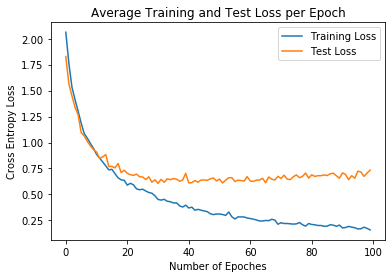

In [0]:
# Plot Loss
plot_loss(loss_train, loss_test)

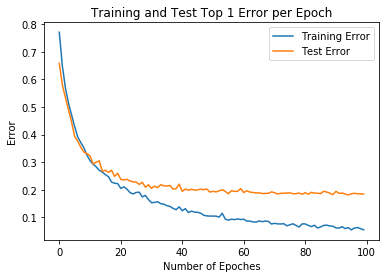

In [0]:
# Plot Top 1 Error
plot_error(top_1_train, top_1_test, top1=True)

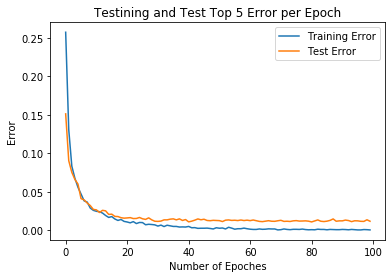

In [0]:
# Plot Top 5 Error
plot_error(top_5_train, top_5_test, top1=False)

**Discussion:**

* Final Test Accuracy: 81.5%
* At Epoch = 100: 
  - Test loss = 0.733
  - Test Top 1 Error Rate = 0.185
  - Test Top 5 Error Rate = 0.012

* As expected, training loss and training errors keep decreasing with more epochs being ran (it converges to 0 for top 5 error rate around epoch 50). 

* However, test loss flattens out around epoch 50 and even slightly increases here and there (partly random / noise as other times I ran the this model, it just flattened out).

* Basically the optimal values for test loss, top 1 error rate and top 5 error rate seemed to have be reached around epoch 50 due to the flattening rate of decrease. Hence, running more epoches would probably not have improved the outcome.

# 3.7 Other Architectures (with lower test accuracy)

#### #1 Network Architecture: Standard 2-layer Network
* Accuracy based on top 1 error rate: 0.7608


This is the network I started with, just 2 convolutional layers, 1 dropout layer without any batch normalisation.

In [0]:
model_standard = CIFAR_classification(100)
print("Standard CNN has accuracy:", model_standard)

Start
Train epoch: 10 loss = 1.235 top-1 error rate  = 0.461 top-5 error rate  = 0.062
Test epoch: 10 loss = 1.184 top-1 error rate  = 0.424 top-5 error rate  = 0.046
Train epoch: 20 loss = 0.957 top-1 error rate  = 0.250 top-5 error rate  = 0.023
Test epoch: 20 loss = 0.913 top-1 error rate  = 0.322 top-5 error rate  = 0.026
Train epoch: 30 loss = 0.824 top-1 error rate  = 0.281 top-5 error rate  = 0.008
Test epoch: 30 loss = 0.867 top-1 error rate  = 0.303 top-5 error rate  = 0.024
Train epoch: 40 loss = 0.712 top-1 error rate  = 0.258 top-5 error rate  = 0.016
Test epoch: 40 loss = 0.786 top-1 error rate  = 0.272 top-5 error rate  = 0.019
Train epoch: 50 loss = 0.670 top-1 error rate  = 0.219 top-5 error rate  = 0.016
Test epoch: 50 loss = 0.747 top-1 error rate  = 0.258 top-5 error rate  = 0.019
Train epoch: 60 loss = 0.607 top-1 error rate  = 0.172 top-5 error rate  = 0.000
Test epoch: 60 loss = 0.714 top-1 error rate  = 0.246 top-5 error rate  = 0.015
Train epoch: 70 loss = 0.537

#### #2 Network Architecture: 3-layer Network without Dropout

* Accuracy based on top 1 error rate: 0.7724

Using a 3-layer network (3 conv layers, 3 pool layers, 1 dense layer) without dropout performed better than #7 Network Architecture --> after this I saw the article on good network architectures and decided to try a version of VGG (#3)

In [0]:
model_nodropout = CIFAR_classification(100)
print("CNN without Drop Out has accuracy:", model_nodropout)

Start
Train epoch: 10 loss = 1.062 top-1 error rate  = 0.336 top-5 error rate  = 0.039
Test epoch: 10 loss = 1.036 top-1 error rate  = 0.369 top-5 error rate  = 0.036
Train epoch: 20 loss = 0.803 top-1 error rate  = 0.289 top-5 error rate  = 0.047
Test epoch: 20 loss = 0.875 top-1 error rate  = 0.302 top-5 error rate  = 0.026
Train epoch: 30 loss = 0.679 top-1 error rate  = 0.266 top-5 error rate  = 0.023
Test epoch: 30 loss = 0.820 top-1 error rate  = 0.281 top-5 error rate  = 0.024
Train epoch: 40 loss = 0.597 top-1 error rate  = 0.234 top-5 error rate  = 0.000
Test epoch: 40 loss = 0.776 top-1 error rate  = 0.267 top-5 error rate  = 0.020
Train epoch: 50 loss = 0.478 top-1 error rate  = 0.203 top-5 error rate  = 0.008
Test epoch: 50 loss = 0.738 top-1 error rate  = 0.242 top-5 error rate  = 0.017
Train epoch: 60 loss = 0.461 top-1 error rate  = 0.203 top-5 error rate  = 0.016
Test epoch: 60 loss = 0.762 top-1 error rate  = 0.241 top-5 error rate  = 0.016
Train epoch: 70 loss = 0.404

#### #3 Network Architecture: 4-layer VGG Network without Dropout

* Accuracy based on top 1 error rate: 0.7853

A 4-layer VGG Network without Dropout I tried with the following specifications: 4 conv layers, 2 pooling layers, 1 dense layer.

The accuracy wasn't as good as I thought it would be so I changed back to a 3-layer standard CNN (the one we did in class) but then added batch normalisation after each convolutional layer (see #4)

In [0]:
model_VGG = CIFAR_classification(100)
print("VGG CNN Model has accuracy:", model_VGG)

Start
Train epoch: 10 loss = 1.298 top-1 error rate  = 0.430 top-5 error rate  = 0.109
Test epoch: 10 loss = 1.207 top-1 error rate  = 0.432 top-5 error rate  = 0.049
Train epoch: 20 loss = 1.056 top-1 error rate  = 0.320 top-5 error rate  = 0.055
Test epoch: 20 loss = 0.941 top-1 error rate  = 0.331 top-5 error rate  = 0.032
Train epoch: 30 loss = 0.864 top-1 error rate  = 0.227 top-5 error rate  = 0.023
Test epoch: 30 loss = 0.848 top-1 error rate  = 0.293 top-5 error rate  = 0.026
Train epoch: 40 loss = 0.775 top-1 error rate  = 0.352 top-5 error rate  = 0.023
Test epoch: 40 loss = 0.806 top-1 error rate  = 0.275 top-5 error rate  = 0.022
Train epoch: 50 loss = 0.698 top-1 error rate  = 0.211 top-5 error rate  = 0.000
Test epoch: 50 loss = 0.730 top-1 error rate  = 0.253 top-5 error rate  = 0.017
Train epoch: 60 loss = 0.667 top-1 error rate  = 0.219 top-5 error rate  = 0.008
Test epoch: 60 loss = 0.703 top-1 error rate  = 0.242 top-5 error rate  = 0.017
Train epoch: 70 loss = 0.629

#### #4 Network Architecture: 3-layer Network with Batch Normalisation

* Accuracy based on top 1 error rate: 0.7879

Using Batch Normalisation after each convolution layer, I got the following specifications: 3 convolutional layers, 3 batch normalisations, 3 pooling layers, 1 dense layer, 4 dropout layers).

Accuracy improved so I wanted to try the batch normalisation on the 4-layer VGG model (#5)


In [0]:
model_batchnorm = CIFAR_classification(100)
print("Batch Normalisation CNN has accuracy:", model_batchnorm)

Start
Train epoch: 10 loss = 1.087 top-1 error rate  = 0.391 top-5 error rate  = 0.023
Test epoch: 10 loss = 1.123 top-1 error rate  = 0.402 top-5 error rate  = 0.040
Train epoch: 20 loss = 0.812 top-1 error rate  = 0.242 top-5 error rate  = 0.000
Test epoch: 20 loss = 0.890 top-1 error rate  = 0.309 top-5 error rate  = 0.023
Train epoch: 30 loss = 0.685 top-1 error rate  = 0.320 top-5 error rate  = 0.016
Test epoch: 30 loss = 0.825 top-1 error rate  = 0.282 top-5 error rate  = 0.023
Train epoch: 40 loss = 0.574 top-1 error rate  = 0.141 top-5 error rate  = 0.008
Test epoch: 40 loss = 0.759 top-1 error rate  = 0.257 top-5 error rate  = 0.020
Train epoch: 50 loss = 0.515 top-1 error rate  = 0.195 top-5 error rate  = 0.008
Test epoch: 50 loss = 0.693 top-1 error rate  = 0.232 top-5 error rate  = 0.015
Train epoch: 60 loss = 0.448 top-1 error rate  = 0.164 top-5 error rate  = 0.000
Test epoch: 60 loss = 0.702 top-1 error rate  = 0.227 top-5 error rate  = 0.017
Train epoch: 70 loss = 0.384

#### #5 Network Architecture: 4-layer VGG Network with Batch Normalisation and Dropout Layers (dropout1: 30%, dropout2: 30%, dropout3: 40%)

* Accuracy based on top 1 error rate: 0.8005

Using Batch Normalisation and Dropout Layers significantly improved the test accuracy from 78% to 80% --> see #3).

Therefore, I wanted to check any differences with dropout %.



In [0]:
model_VGG_batchnorm = CIFAR_classification(100)
print("VGG CNN Model with Batch Normalisation has accuracy:", model_VGG_batchnorm)

Start
Train epoch: 10 loss = 1.233 top-1 error rate  = 0.547 top-5 error rate  = 0.055
Test epoch: 10 loss = 1.117 top-1 error rate  = 0.403 top-5 error rate  = 0.041
Train epoch: 20 loss = 0.947 top-1 error rate  = 0.367 top-5 error rate  = 0.023
Test epoch: 20 loss = 0.870 top-1 error rate  = 0.303 top-5 error rate  = 0.025
Train epoch: 30 loss = 0.806 top-1 error rate  = 0.305 top-5 error rate  = 0.023
Test epoch: 30 loss = 0.740 top-1 error rate  = 0.255 top-5 error rate  = 0.018
Train epoch: 40 loss = 0.719 top-1 error rate  = 0.242 top-5 error rate  = 0.016
Test epoch: 40 loss = 0.711 top-1 error rate  = 0.245 top-5 error rate  = 0.017
Train epoch: 50 loss = 0.682 top-1 error rate  = 0.250 top-5 error rate  = 0.000
Test epoch: 50 loss = 0.686 top-1 error rate  = 0.237 top-5 error rate  = 0.016
Train epoch: 60 loss = 0.607 top-1 error rate  = 0.180 top-5 error rate  = 0.016
Test epoch: 60 loss = 0.649 top-1 error rate  = 0.221 top-5 error rate  = 0.015
Train epoch: 70 loss = 0.573

#### #6 Network Architecture: 4-layer VGG Network with Batch Normalisation and Dropout Layers (dropout1: 20%, dropout2: 20%, dropout3: 40%)

* Accuracy based on top 1 error rate: 0.8064

Trying out the different dropout %, it improved test accuracy a little bit. For the final model, I decided to add another layer for the VGG Network, closely resembling the true VGG-16 network architecture.

In [0]:
model_VGG_batchnorm = CIFAR_classification(100)
print("VGG CNN Model with Batch Normalisation has accuracy:", model_VGG_batchnorm)

Start
Train epoch: 10 loss = 0.976 top-1 error rate  = 0.445 top-5 error rate  = 0.062
Test epoch: 10 loss = 1.024 top-1 error rate  = 0.359 top-5 error rate  = 0.036
Train epoch: 20 loss = 0.675 top-1 error rate  = 0.258 top-5 error rate  = 0.016
Test epoch: 20 loss = 0.734 top-1 error rate  = 0.249 top-5 error rate  = 0.018
Train epoch: 30 loss = 0.491 top-1 error rate  = 0.180 top-5 error rate  = 0.000
Test epoch: 30 loss = 0.682 top-1 error rate  = 0.230 top-5 error rate  = 0.015
Train epoch: 40 loss = 0.420 top-1 error rate  = 0.109 top-5 error rate  = 0.008
Test epoch: 40 loss = 0.657 top-1 error rate  = 0.217 top-5 error rate  = 0.014
Train epoch: 50 loss = 0.345 top-1 error rate  = 0.164 top-5 error rate  = 0.000
Test epoch: 50 loss = 0.679 top-1 error rate  = 0.211 top-5 error rate  = 0.014
Train epoch: 60 loss = 0.280 top-1 error rate  = 0.062 top-5 error rate  = 0.000
Test epoch: 60 loss = 0.688 top-1 error rate  = 0.207 top-5 error rate  = 0.014
Train epoch: 70 loss = 0.240

# 3.8 References

P1:
1. SoftMax Regression: https://www.geeksforgeeks.org/softmax-regression-using-tensorflow/
2. Batch Training: https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html
3. Optimisers: https://ruder.io/optimizing-gradient-descent/

P2 & P3
4. CIFAR-10 Classification & Normalisation Function: https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c
5. Different Architectures: https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#c5a6
6. VGG-16 Model Inspiration: https://neurohive.io/en/popular-networks/vgg16/
7. CIFAR-10 Classification Architecture: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

